In [1]:
import sys
import pandas
import numpy as np

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['font.family'] = 'sans-serif'
plt.style.use('ggplot')

In [3]:
#!pip install pandas
#!pip install xlrd
!pip install openpyxl

In [4]:
# input data
# stale path = '/Users/ksaniee/Desktop/CCU_data/CCU-database-repo/data/'
import os
print("Current absolute path is")
print(os.path.abspath("."))

Current absolute path is
/Users/chloeymoon/Documents/Columbia/CCU-database-repo/dataProcessing


In [5]:
path = '..' #back to root from dataProcessing
pathToRooth = '..'
print(pathToRooth)
pathToDataIn = pathToRooth + '/data/dataIn/'
print(pathToDataIn)

..
../data/dataIn/


In [6]:
filename = 'CCU_patientData_allPatients_active.xlsx'
sheetname = 'patientData'

with pd.ExcelFile(pathToDataIn+filename) as xls:
#with pd.ExcelFile(path+'data/dataIn/'+filename) as xls:
    df = pd.read_excel(xls, sheetname, index_col=None, na_values=['NA'])

In [7]:
# patients in CCU are not yet discharged
current_patients = df['CCU Discharge Date Formatted'].isna()

# alternatively, use: current_patients = df['CCU Status']=='In CCU'

In [8]:
# calculate average days of intubation for intubated patients

intubated = ~df[current_patients]['Date of intubation'].isna()
still_intubated = df[current_patients][intubated]['Date of extubation or trach'].isna()
today = pd.to_datetime('today')
days_intubated = df[current_patients][intubated]['Date of extubation or trach'].fillna(today) - pd.to_datetime(df[current_patients][intubated]['Date of intubation'])
days_still_intubated = today - df[current_patients][intubated][still_intubated]['Date of intubation']

In [9]:
# replace dots with NaN

df['Start Date of Paralytics'] = df['Start Date of Paralytics'].replace('.',np.nan)
df['Date started CVVH'] = df['Date started CVVH'].replace('.',np.nan)
df['End date for CVVH'] = df['End date for CVVH'].replace('.',np.nan)

In [10]:
# calculate average days of paralysis for paralyzed patients 

paralyzed = ~df[current_patients]['Start Date of Paralytics'].isna()
days_paralyzed = df[current_patients][paralyzed]['Stop date of paralytics'].fillna(today) - pd.to_datetime(df[current_patients][paralyzed]['Start Date of Paralytics'])
still_paralyzed = df[current_patients][paralyzed]['Stop date of paralytics'].isna()
days_still_paralyzed = today - df[current_patients][paralyzed][still_paralyzed]['Start Date of Paralytics']

In [11]:
# calculate average days on CVVH

def try_date(d):
    try: return pd.to_datetime(d)
    except: return np.nan

cvvh = ~df[current_patients]['Date started CVVH'].isna()
still_cvvh = df[current_patients][cvvh]['End date for CVVH'].isna()
days_cvvh = df[current_patients][cvvh]['End date for CVVH'].apply(try_date).fillna(today) - pd.to_datetime(df[current_patients][cvvh]['Date started CVVH'])
days_still_cvvh = today - df[current_patients][cvvh][still_cvvh]['Date started CVVH']

# Aggregated data structure

In [19]:
rec = pd.DataFrame(
    [df[current_patients].shape[0],                       # Number_of_patients_in_CCUs
     df[current_patients]['Age'].mean(),                  # Age_average
     (df[current_patients]['Gender']=='M').sum(),         # Gender_M
     (df[current_patients]['Gender']=='F').sum(),         # Gender_F
     (df[current_patients]['Race']=='Asian/Indian').sum(), # Race_AsianIndian
     (df[current_patients]['Race']=='Black').sum(),        # Race_Black
     (df[current_patients]['Race']=='White').sum(),        # Race_White
     (df[current_patients]['Race']=='Other').sum(),        # Race_Other
     (df[current_patients]['Race']=='Declined').sum(),     # Race_Declined
     (df[current_patients]['Ethnicity']=='Declined').sum(), # Ethnicity_Declined
     (df[current_patients]['Ethnicity']=='Hispanic').sum(), # Ethnicity_Hispanic
     (df[current_patients]['Ethnicity']=='Not Hispanic').sum(), # Ethnicity_NotHispanic
     (df[current_patients]['CCU Location']=='MCCU').sum(),      # CCU_Location_MCCU
     (df[current_patients]['CCU Location']=='HCCU').sum(),      # CCU_Location_HCCU
     df[current_patients]['CCU LOS'].mean(),                    # CCU_LOS_Average_onToday
     (df[current_patients]['COVID+ (Y/N/NT not tested)']=='Y').sum(), # COVID+_Y
     (df[current_patients]['COVID+ (Y/N/NT not tested)']=='N').sum(), # COVID+_N
     (df[current_patients]['COVID+ (Y/N/NT not tested)']=='NT').sum(), # COVID+_NT
     (df[current_patients]['Intubated']=='Yes').sum(),                 # Intubated_Y
     (df[current_patients]['Intubated']=='No').sum(),                  # Intubated_N
     (df[current_patients]['Trach (Yes/No)']=='Yes').sum(),            # Trach_(Yes/No)_Y
     (df[current_patients]['Trach (Yes/No)']=='No').sum(),            # Trach_(Yes/No)_N
     days_still_intubated.apply(lambda x: x/np.timedelta64(1,'D')).mean(),  # Days_Intubated_average_numberOfDays
     (df[current_patients]['Known to CHF Formatted']=='CHF').sum(),   # Known_to_CHF_service_Y 
     (df[current_patients]['Known to CHF Formatted']=='No').sum(),    # Known_to_CHF_service_N
     (df[current_patients]['Mechanical Support Formatted']=='IABP').sum(), # Mechanical_support_Y-IABP
     (df[current_patients]['Mechanical Support Formatted']=='No').sum(), # Mechanical_support_N
     (~df[current_patients]['Start Date of Paralytics'].isna()).sum(), # Paralytics_while_in_CCU_Y
     (df[current_patients]['Start Date of Paralytics'].isna()).sum(),  # Paralytics_while_in_CCU_N
     days_still_paralyzed.apply(lambda x: x/np.timedelta64(1,'D')).mean(),  # Days_Paralyzed_average
     days_paralyzed.apply(lambda x: x/np.timedelta64(1,'D')).mean(),  # Days_Paralyzed_total
     (~df[current_patients]['Date started CVVH'].isna()).sum(),       # CVVH (y/n)_Y
     (df[current_patients]['Date started CVVH'].isna()).sum(),       # CVVH (y/n)_N
     days_still_cvvh.apply(lambda x: x/np.timedelta64(1,'D')).mean(),      # Days_on_CVVH_average
     (df[current_patients]['Proned']=='Y').sum(),                     # Proned_Y
     (df[current_patients]['Proned']=='N').sum(),                     # Proned_N
     (df[current_patients]['iNo']=='Y').sum(),                        # iNo_Y
     (df[current_patients]['iNo']=='N').sum()],                        # iNo_N
     index=['Number_of_patients_in_CCUs','Age_average','Gender_M','Gender_F','Race_AsianIndian',
          'Race_Black','Race_White','Race_Other','Race_Declined','Ethnicity_Declined',
          'Ethnicity_Hispanic','Ethnicity_NotHispanic','CCU_Location_MCCU','CCU_Location_HCCU',
          'CCU_LOS_Average_onToday','COVID+_Y','COVID+_N','COVID+_NT','Intubated_Y','Intubated_N',
          'Trach_(Yes/No)_Y','Trach_(Yes/No)_N','Days_Intubated_average_numberOfDays',
          'Known_to_CHF_service_Y','Known_to_CHF_service_N','Mechanical_support_Y-IABP','Mechanical_support_N',
            'Paralytics_while_in_CCU_Y','Paralytics_while_in_CCU_N', 'Days_Paralyzed_average','Days_Paralyzed_total','CVVH (y/n)_Y','CVVH (y/n)_N','Days_on_CVVH_average',
            'Proned_Y','Proned_N','iNo_Y','iNo_N'],
    columns=[today.date()]).T #columns=[today.date()]



In [20]:
# write record to spreadsheet

pathToDataOut = pathToRooth + '/data/dataOut/'
#outfile = path+'dataOut/'+'CCU_patientStatistics_aggregate_active_test.xlsx'
#outfile = pathToDataOut+'CCU_patientStatistics_aggregate_active_test.xlsx'
outfile = pathToDataOut+'CCU_patientStatistics_aggregate_active.xlsx'

rec.to_excel(outfile,sheet_name='patientStatisticsDaily')

# Histogram outputs

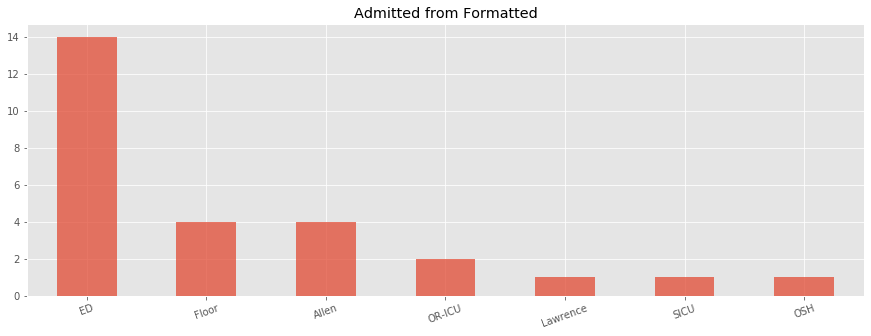

In [14]:
df[current_patients]['Admitted from Formatted'].value_counts().plot(kind='bar',title='Admitted from Formatted',rot=20,alpha=0.75)

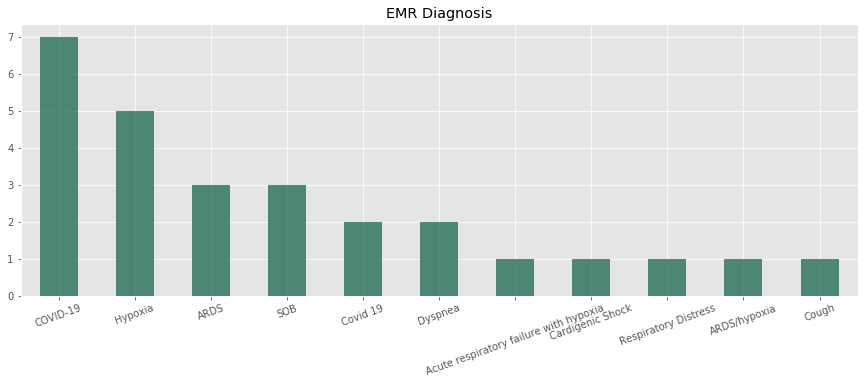

In [15]:
df[current_patients]['EMR Diagnosis'].value_counts().plot(kind='bar',title='EMR Diagnosis',rot=20,alpha=0.75,color=(0.1,0.4,0.3))

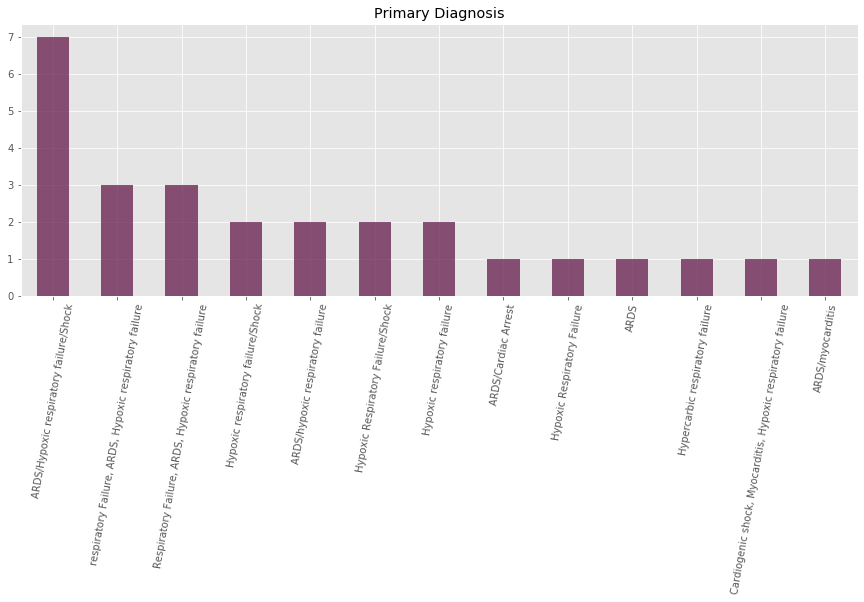

In [16]:
df[current_patients]['CCU primary diagnosis'].value_counts().plot(kind='bar',title='Primary Diagnosis',rot=80,alpha=0.75,color=(0.4,0.1,0.3))

In [17]:
df[current_patients]['Discharged to'].value_counts().plot(kind='bar',title='Discharged to',rot=20,alpha=0.75,color=(0.4,0.5,0.3))

TypeError: no numeric data to plot

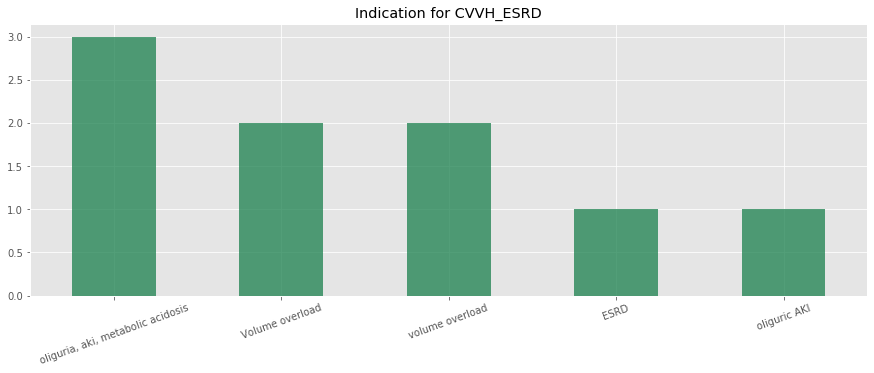

In [18]:
df[current_patients]['Indication for CVVH'].value_counts().plot(kind='bar',title='Indication for CVVH_ESRD',rot=20,alpha=0.75,color=(0.1,0.5,0.3))

Notes:

'Discharged to' currently has no entries among current patients

Issue with 'Deceased Y/N (In CCU)' column name needs to be resolved (remove line break)

Are any machines shared between patients?

What is the Hospital Status field?

Does Marwah actually want the Days_Paralyzed_total as an aggregate measure, or total days for each paralyzed patient? Same for CVVH, Intubated.